In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import iglob
from math import sqrt
from scipy.io import wavfile
from scipy.signal import spectrogram
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from itertools import zip_longest

from keras.layers import LSTM, Dense, Convolution1D
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed, Bidirectional

from scipy.signal import resample

%matplotlib inline

Using TensorFlow backend.


In [2]:
tf.__version__

'1.2.0'

In [3]:
SAMPLE_RATE = 8000

In [4]:
def list_2d_to_sparse(list_of_lists):
    indices, values = [], []
    for i, sublist in enumerate(list_of_lists):
        for j, value in enumerate(sublist):
            indices.append([i, j])
            values.append(value)
    shape = [len(list_of_lists), max(map(len, list_of_lists))]
    return (np.array(indices), np.array(values), np.array(shape))

def batch(X, y, batch_size):
    num_features = X[0].shape[1]
    n = len(X)
    perm = np.random.permutation(n)
    for batch_ind in np.resize(perm, (n // batch_size, batch_size)):
        X_batch, y_batch = [X[i] for i in batch_ind], [y[i] for i in batch_ind]
        sequence_lengths = list(map(len, X_batch))
        X_batch_padded = np.array(list(zip_longest(*X_batch, fillvalue=np.zeros(num_features)))).transpose([1, 0, 2])
        yield X_batch_padded, sequence_lengths, list_2d_to_sparse(y_batch), y_batch
        
def decode(d, mapping):
    """Decode."""
    shape = d.dense_shape
    batch_size = shape[0]
    ans = np.zeros(shape=shape, dtype=int)
    seq_lengths = np.zeros(shape=(batch_size, ), dtype=np.int)
    for ind, val in zip(d.indices, d.values):
        ans[ind[0], ind[1]] = val
        seq_lengths[ind[0]] = max(seq_lengths[ind[0]], ind[1] + 1)
    ret = []
    for i in range(batch_size):
        ret.append("".join(map(lambda s: mapping[s], ans[i, :seq_lengths[i]])))
    return ret


In [5]:
def normalize(data):
    if data.dtype == np.uint8:
        return (data.astype(np.float) - 128) / 128
    elif data.dtype == np.int16:
        return (data.astype(np.float)) / 2 ** 15


def read_wav(path):
    _, data = wavfile.read(path)
    data = normalize(data)
    if len(data.shape) > 1:
        data = data[:, 0]
    return data

In [6]:
FILE_PATH = "free-spoken-digit-dataset/recordings/1_jackson_3.wav"
SAMPLE_RATE = 8000

In [7]:
data = read_wav(FILE_PATH)

In [8]:
Audio(FILE_PATH)

In [9]:
def extract_feats(data):
    offset_frames = int(SAMPLE_RATE * 0.01)
    window_frames = int(SAMPLE_RATE * 0.025)
    fs, ts, Sxx = spectrogram(data, SAMPLE_RATE, nperseg=window_frames, noverlap=window_frames-offset_frames)
    Sxx = np.log(1e-9 + Sxx)
    # plt.pcolor(ts, fs, Sxx, cmap="inferno")
    return Sxx

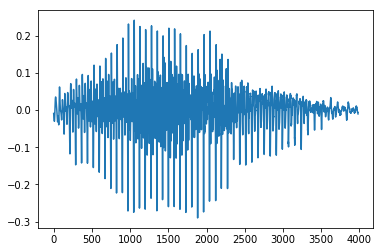

In [10]:
plt.plot(data)

In [11]:
lexicon = {
    0: "zero",
    1: "one",
    2: "two",
    3: "three",
    4: "four",
    5: "five",
    6: "six",
    7: "seven",
    8: "eight",
    9: "nine"
}

vocabulary = {chr(ord("a") + i): i for i in range(26)}
vocabulary[" "] = len(vocabulary)
inv_vocabulary = dict(zip(vocabulary.values(), vocabulary.keys()))

In [12]:
X = []
y = []
for filename in iglob("data/*.wav"):
    digits = map(int, os.path.basename(filename).split("__")[0].split("_"))
    data = read_wav(filename)
    X.append(extract_feats(data).T)
    y.append(list(map(lambda x: vocabulary[x], " ".join(map(lambda x: lexicon[x], digits)))))

n = len(X)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

'seven eight'

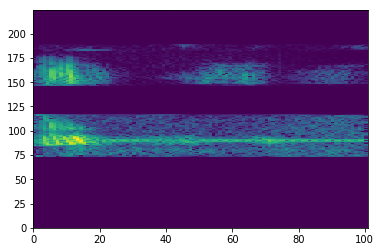

In [14]:
idx = 1
plt.pcolor(X_train[idx])
"".join(map(lambda x: inv_vocabulary[x], y_train[idx]))

In [18]:
g = tf.Graph()
with g.as_default():
    input_X = tf.placeholder(tf.float32, shape=[None, None, 101])
    labels = tf.sparse_placeholder(tf.int32)
    seq_lens = tf.placeholder(tf.int32, shape=[None])


    model = Sequential()
    model.add(Convolution1D(64, 5, padding='same', input_shape=(None, 101)))
    model.add(Convolution1D(64, 5, strides=2, padding='same'))
    model.add(Convolution1D(128, 5, padding='same'))
    model.add(Convolution1D(128, 5, strides=2, padding='same'))
    model.add(Bidirectional(LSTM(128, return_sequences=True, implementation=2)))
    model.add(TimeDistributed(Dense(len(vocabulary) + 1)))
    
    final_seq_lens = tf.cast(tf.ceil(tf.cast(tf.ceil(seq_lens / 2), tf.int32) / 2), tf.int32)

    logits = model(input_X)
    print(logits)
    logits = tf.transpose(logits, [1, 0, 2])

    ctc_loss = tf.reduce_mean(tf.nn.ctc_loss(labels, logits, final_seq_lens))
    # ctc_greedy_decoder? merge_repeated=True
    (decoded, ), _ = tf.nn.ctc_greedy_decoder(logits, final_seq_lens)
    ler = tf.reduce_mean(tf.edit_distance(tf.cast(decoded, tf.int32), labels))

    train_op = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(ctc_loss)

Tensor("sequential_1/time_distributed_1/Reshape_1:0", shape=(?, ?, 28), dtype=float32)


In [19]:
sess = tf.InteractiveSession(graph=g)

In [21]:
sess.run(tf.global_variables_initializer())
for epoch in range(1000):
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_train, y_train, 64):
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        train_loss, train_ler, train_decoded, true, _ = sess.run([ctc_loss, ler, decoded, labels, train_op], feed_dict=feed_dict)
    for X_batch, seq_lens_batch, y_batch, y_batch_orig in batch(X_test, y_test, 64):
        feed_dict = {
            input_X: X_batch,
            labels: y_batch,
            seq_lens: seq_lens_batch
        }
        test_loss, test_ler, test_decoded, true = sess.run([ctc_loss, ler, decoded, labels], feed_dict=feed_dict)
    print(f"{epoch}", train_loss, train_ler, decode(train_decoded, inv_vocabulary)[:10],  test_loss, test_ler)

0 25.9691 1.0 ['', '', '', '', '', '', '', '', '', ''] 25.8702 1.0
1 25.1709 1.0 ['', '', '', '', '', '', '', '', '', ''] 24.4147 1.0
2 25.4605 1.0 ['', '', '', '', '', '', '', '', '', ''] 27.7781 1.0
3 21.8964 1.0 ['', '', '', '', '', '', '', '', '', ''] 24.4684 1.0
4 25.5411 1.0 ['', '', '', '', '', '', '', '', '', ''] 26.0054 1.0
5 27.3518 1.0 ['', '', '', '', '', '', '', '', '', ''] 25.6213 1.0
6 23.519 0.971584 ['f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f'] 25.4287 0.968241
7 21.9425 0.948049 ['t', 't', 't', 't', 't', 't', 't', 't', 't', 't'] 23.4073 0.940685
8 22.3008 0.901432 ['fe', 'fe', 'fe', 'f', 'fe', 'f', 'f', 'fe', 'fe', 'fe'] 26.3196 0.882563
9 23.7424 0.854202 ['te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te'] 24.258 0.837414
10 21.3676 0.841927 ['te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te', 'te'] 24.8711 0.854045
11 22.8359 0.915853 ['te', 't', 't', 't', 't', 't', 't', 't', 'te', 't'] 23.1624 0.840567
12 23.3829 0.878296 ['se', 'se', 'se', 'se', 's

81 21.7721 0.794979 ['sine', 'fe', 'sine', 'sie', 'sie', 'tie', 'sine', 'fe', 'fe', 'fe'] 22.1452 0.793394
82 22.2597 0.7957 ['tine', 'tie', 'tine', 'tie', 'fe', 'tie', 'tine', 'tie', 'tie', 'fe'] 20.6444 0.818329
83 20.0878 0.794301 ['sie', 'sine', 'sine', 'sie', 'sie', 'sie', 'sie', 'sie', 'sie', 'sie'] 21.0014 0.806186
84 19.8422 0.81512 ['fie', 'si', 'sie', 'fi', 'fie', 'sie', 'fie', 'fi', 'sie', 'sie'] 21.7345 0.801602
85 23.6335 0.813331 ['fine', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie', 'fie'] 21.5725 0.803146
86 21.6107 0.837396 ['fie', 'si', 'fi', 'tie', 'tie', 'fi', 'sine', 'fie', 'tie', 'tie'] 20.9285 0.793597
87 21.5916 0.806213 ['fine', 'fie', 'fine', 'fie', 'fie', 'fie', 'fi', 'fie', 'fie', 'fie'] 24.4083 0.802279
88 19.4532 0.773226 ['tie', 'tie', 'tie', 'tie', 'tie', 'tie', 'fie', 'fie', 'tie', 'sie'] 23.2244 0.809644
89 19.9542 0.828472 ['sie', 'si', 'si', 'sie', 'sie', 'sine', 'sie', 'sie', 'sie', 'sie'] 22.4438 0.819208
90 20.3346 0.760722 ['fie', 'fie'

151 12.1028 0.460958 ['five fie', 'fine', 'siuh', 'fine firo', 'fiur four eigh', 'sive', 'sigh', 'tire fine eix', 'finro five e', 'sien'] 12.7865 0.460242
152 13.0472 0.493493 ['fine tio fine', 'five firo five', 'fiur gh', 'firo eine ei', 'fiur ie x', 'five fivine', 'tio', 'five five eive', 'fiur tr', 'tiro exe fino'] 10.7245 0.397619
153 10.6465 0.479542 ['tiro', 'siven tie tii', 'tio sigh', 'tieo fine', 'tio fine tiro', 'five ene to', 'sine', 'siven', 'six', 'ti ix igh'] 10.9974 0.43379
154 11.2536 0.435025 ['tire', 'fiur tiro fine', 'siven', 'tiro eiro', 'fine', 'tie', 'tine', 'fine ire', 'tiro', 'fiur fiur'] 11.2266 0.477759
155 10.7215 0.439957 ['fight ur', 'fine fivr eive', 'fiue firo', 'tio tiro', 'fiur', 'fix fivo five', 'fine', 'fiur fiue', 'fiur fine', 'sine'] 12.1684 0.414638
156 11.5662 0.422847 ['tiro sigh', 'tio fine', 'five ive', 'fine ine tir', 'fivx eino ero', 'five fivh ine', 'sive igh', 'tw', 'tir eive ive', 'tiro ti'] 10.2165 0.387001
157 11.2555 0.418031 ['sivx eiv

202 5.86183 0.171609 ['four four', 'tero sixe sight', 'six sght', 'the ight', 'six', 'fix four siven', 'tho five', 'sight', 'sight sight', 'three sirx siven'] 4.82653 0.155013
203 5.75735 0.161239 ['five siven', 'three six', 'zero twree', 'four fegxt one', 'two four five', 'si five', 'tho sine', 'tero zero nine', 'six zero', 'siven'] 5.91684 0.175391
204 5.15741 0.162682 ['four sight', 'sight six', 'fone siven', 'the siven', 'sight', 'three eine six', 'fove foive siven', 'six', 'thro nine', 'zero'] 5.68808 0.167546
205 4.97907 0.161862 ['four four', 'twro fone sx', 'two one', 'six', 'four', 'four four foxr', 'sive six', 'fove one', 'one', 'two'] 5.73441 0.182976
206 4.83962 0.138403 ['fiur eight', 'four', 'fone', 'sine tho siven', 'six', 'five', 'six', 'zeree four', 'sive sine thee', 'fone zero nine'] 4.91608 0.157189
207 5.7572 0.184666 ['oine eight', 'siven fight ve', 'four fove', 'six fix four', 'fone sive', 'fine', 'nine', 'sive', 'twee', 'six zero nine'] 5.03299 0.178572
208 4.315

252 1.50071 0.0289652 ['zero five six', 'eight to', 'zero', 'zero zeo seven', 'four six zero', 'one eight', 'nine', 'seven zero', 'two one three', 'eight seven two'] 1.59102 0.0443159
253 1.03925 0.0113033 ['nine three', 'zero three eight', 'nine seven three', 'tho three eight', 'nine four five', 'one nine', 'nine', 'sive nine eight', 'four eight', 'nine'] 1.49917 0.0384401
254 1.23077 0.0129562 ['seven nine five', 'three eight', 'eight eeight seven', 'five', 'two', 'nine zero six', 'seven one zero', 'seven two eight', 'nine', 'two'] 1.65482 0.0297788
255 1.08484 0.0083494 ['five one', 'zero three', 'eight six', 'eight eght', 'nine', 'seven seven', 'five one nine', 'two', 'eight', 'two'] 1.40561 0.0334597
256 1.30361 0.0242906 ['six five', 'fight five seven', 'eight zero zero', 'one', 'eight two', 'three three', 'eight', 'zero', 'nine six', 'three four four'] 1.24168 0.0182468
257 1.08946 0.0126335 ['tho three', 'seven nine', 'eight seven four', 'four', 'zero three', 'seven', 'eight si

KeyboardInterrupt: 

In [40]:
with g.as_default():
    (decoded_beam, ), _ = tf.nn.ctc_beam_search_decoder(logits, final_seq_lens)

In [34]:
Audio("data/5_3_0__157a29673500e843c71d196a5a95585f.wav")

In [43]:
feats = extract_feats(read_wav("my_three.wav")).T

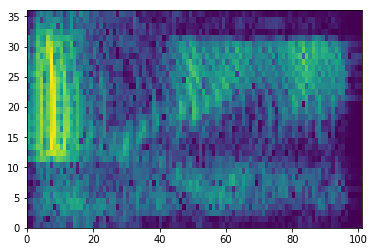

In [44]:
plt.pcolor(feats)

In [45]:
test_decoded = sess.run(decoded_beam, feed_dict={input_X: feats.reshape((1, -1, 101)), seq_lens: [len(feats)]})

In [46]:
decode(test_decoded, inv_vocabulary)

['t']

In [79]:
x = read_wav("my_three_two_four.wav")

In [60]:
y = read_wav("two.wav")

In [87]:
def add_noise(x, scale=0.0005):
    return x + np.random.normal(scale=scale, size=x.shape)

In [88]:
Audio(data=add_noise(np.concatenate([x, np.zeros(int(1.2 * SAMPLE_RATE), dtype=np.float32), y])), rate=8000)

In [89]:
feats = extract_feats(np.random.normal(scale=0.1, size=10000))

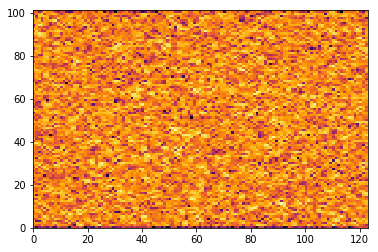

In [90]:
plt.pcolor(feats, cmap="inferno")

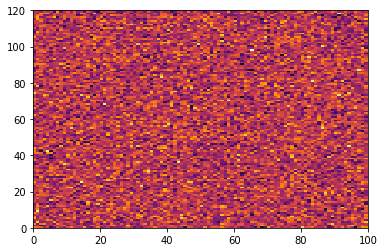

In [92]:
plt.pcolor(np.random.normal(size=(120, 100)), cmap="inferno")

In [189]:
x = np.cumsum(np.random.normal(0.0, scale=0.1, size=500000))

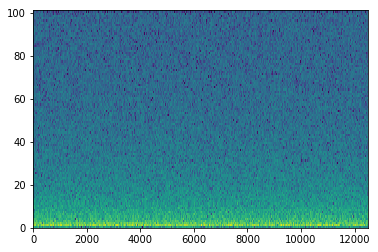

In [176]:
plt.pcolor(extract_feats(x))

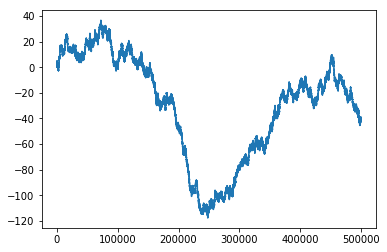

In [190]:
plt.plot(x)

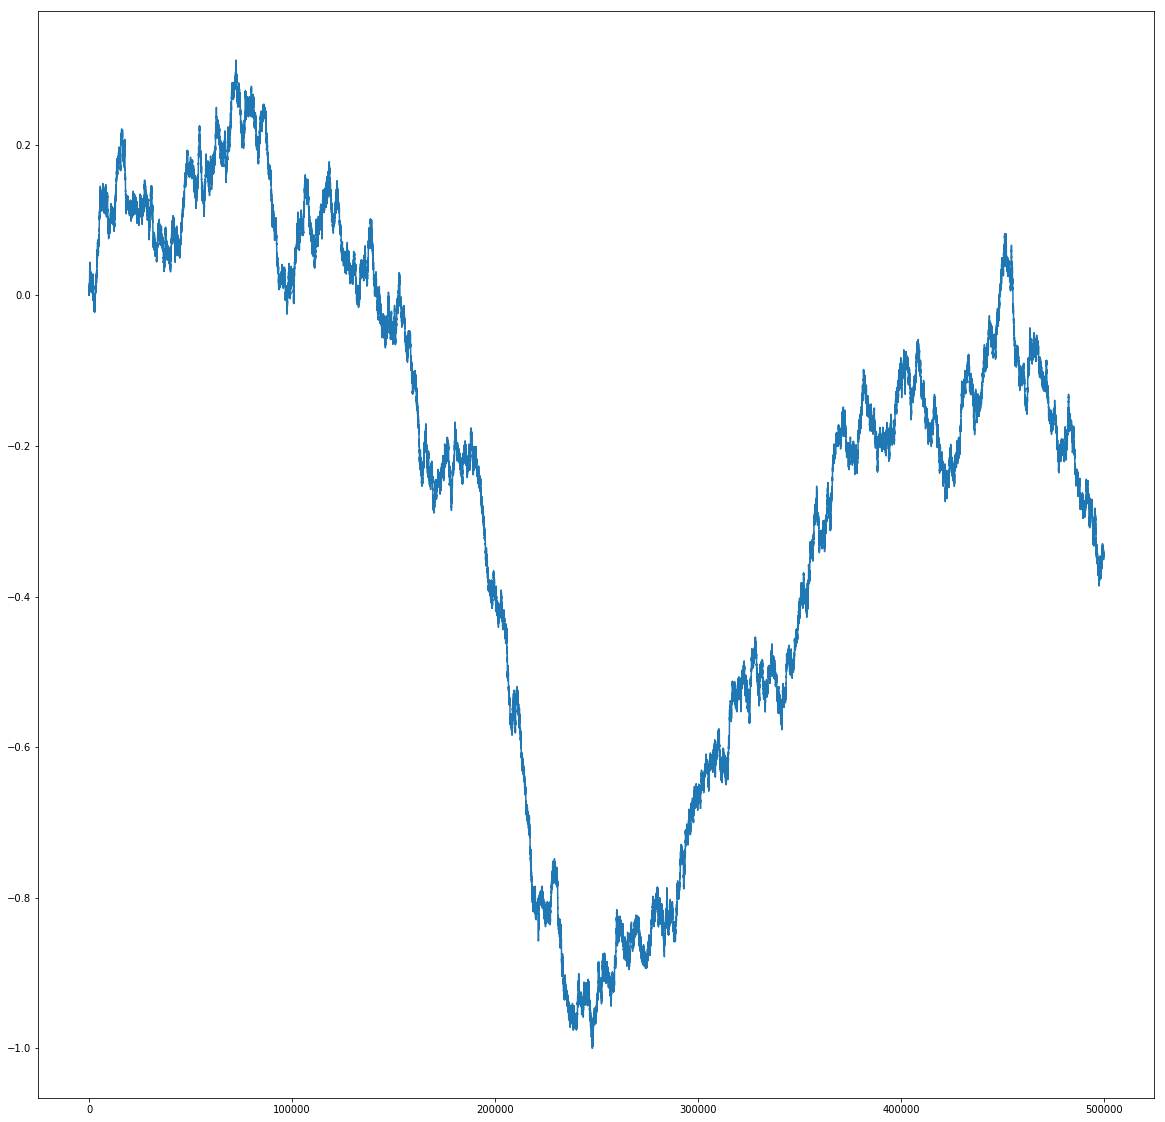

In [191]:
plt.figure(figsize=(20, 20))
plt.plot((x / np.abs(x).max()))

In [192]:
audio = x / np.abs(x).max()

In [193]:
audio_4000 = resample(audio, len(audio) * 2)

In [194]:
len(audio_4000)

1000000

In [195]:
Audio(data=audio_4000, rate=32000)

In [149]:
Audio(data=np.random.normal(scale=0.0000001, size=100000), rate=8000)